<h1>Training a Parts of speech tagger using NLTK tree bank data set </h1>

citations: https://github.com/PacktPublishing/Hands-On-Natural-Language-Processing-with-Python/blob/master/Chapter02/02_example.ipynb

In [1]:
import nltk
import numpy as np
from nltk import word_tokenize
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [2]:
%matplotlib inline

In [3]:
# nltk.download('treebank')
# nltk.download('universal_tagset')

In [4]:
RANDOM_STATE = 0

First, we download our dataset, Penn Treebank. It includes a large annotated corpus of English text used in NLP research and applications.

In [5]:
tagged_sentences = nltk.corpus.treebank.tagged_sents(tagset='universal')

In [6]:
len(tagged_sentences)

3914

In [7]:
tagged_sentences[0]

[('Pierre', 'NOUN'),
 ('Vinken', 'NOUN'),
 (',', '.'),
 ('61', 'NUM'),
 ('years', 'NOUN'),
 ('old', 'ADJ'),
 (',', '.'),
 ('will', 'VERB'),
 ('join', 'VERB'),
 ('the', 'DET'),
 ('board', 'NOUN'),
 ('as', 'ADP'),
 ('a', 'DET'),
 ('nonexecutive', 'ADJ'),
 ('director', 'NOUN'),
 ('Nov.', 'NOUN'),
 ('29', 'NUM'),
 ('.', '.')]

Next, we define some functions that will be helpful for feature engineering, processing, etc.

In [8]:
def create_features(st: list, ix: int) -> dict:
    """
    Creates features for a word in a treebank sentence.
    
    Args:
        st (list): a list of tagged sentences from nltk treebank
        ix: (int): index that refers to the word in the sentence
    
    Returns:
        d_ft (dict): a dictionary of feature values
    """
    d_ft = {}
    d_ft['word'] = st[ix]
    d_ft['dist_from_first'] = ix - 0
    d_ft['dist_from_last'] = len(st) - ix
    d_ft['capitalized'] = st[ix][0].upper() == st[ix][0]
    d_ft['prefix1'] = st[ix][0]
    d_ft['prefix2'] = st[ix][:2]
    d_ft['prefix3'] = st[ix][:3]
    d_ft['suffix1'] = st[ix][-1]
    d_ft['suffix2'] = st[ix][-2:]
    d_ft['suffix3'] = st[ix][-3:]
    d_ft['prev_word'] = '' if ix==0 else st[ix-1]
    d_ft['next_word'] = '' if ix==(len(st)-1) else st[ix+1]
    d_ft['numeric'] = st[ix].isdigit()
    return d_ft

In [9]:
def get_untagged_sentence(tagged_sentence):
    s, t = zip(*tagged_sentence)
    return list(s)

In [10]:
# example useage
get_untagged_sentence(tagged_sentences[0])

['Pierre',
 'Vinken',
 ',',
 '61',
 'years',
 'old',
 ',',
 'will',
 'join',
 'the',
 'board',
 'as',
 'a',
 'nonexecutive',
 'director',
 'Nov.',
 '29',
 '.']

In [11]:
def extract_features(tagged_sentences):
    """
    Extracts features and labels from treebank corpus.
    """
    features, labels = [], []
 
    for sentence in tagged_sentences:
        for token_idx in range(len(sentence)):
            features.append(create_features(get_untagged_sentence(sentence), token_idx))
            labels.append(sentence[token_idx][1]) # token label is in second position
 
    return features, labels

In [12]:
X, y = extract_features(tagged_sentences)

In [13]:
X[:2]

[{'word': 'Pierre',
  'dist_from_first': 0,
  'dist_from_last': 18,
  'capitalized': True,
  'prefix1': 'P',
  'prefix2': 'Pi',
  'prefix3': 'Pie',
  'suffix1': 'e',
  'suffix2': 're',
  'suffix3': 'rre',
  'prev_word': '',
  'next_word': 'Vinken',
  'numeric': False},
 {'word': 'Vinken',
  'dist_from_first': 1,
  'dist_from_last': 17,
  'capitalized': True,
  'prefix1': 'V',
  'prefix2': 'Vi',
  'prefix3': 'Vin',
  'suffix1': 'n',
  'suffix2': 'en',
  'suffix3': 'ken',
  'prev_word': 'Pierre',
  'next_word': ',',
  'numeric': False}]

In [14]:
y[:2]

['NOUN', 'NOUN']

In [15]:
n_sample = 10_000
dict_vectorizer = DictVectorizer(sparse=False)
X_transformed = dict_vectorizer.fit_transform(X[0:n_sample])
y_sampled = y[0:n_sample]

In [16]:
X_transformed.shape

(10000, 11497)

In [17]:
dict_vectorizer.get_feature_names_out()

array(['capitalized', 'dist_from_first', 'dist_from_last', ...,
       'word=yielding', 'word=yields', 'word=you'], dtype=object)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y_sampled, test_size=0.2, random_state=RANDOM_STATE)

In [19]:
rf = RandomForestClassifier(n_jobs=2)
rf.fit(X_train,y_train)

RandomForestClassifier(n_jobs=2)

In [22]:
def predict_pos_tags(sentence):
    tagged_sentence = []
    features = [create_features(sentence, index) for index in range(len(sentence))]
    features = dict_vectorizer.transform(features)
    tags = rf.predict(features)
    return zip(sentence, tags)

In [23]:
test_sentence = "This is a simple POS tagger"
for tagged in predict_pos_tags(test_sentence.split()):
    print(tagged)

('This', 'DET')
('is', 'VERB')
('a', 'DET')
('simple', 'ADJ')
('POS', 'NOUN')
('tagger', 'NOUN')


In [24]:
predictions = rf.predict(X_test)

In [25]:
accuracy_score(y_test,predictions)

0.935

In [26]:
conf_matrix = confusion_matrix(y_test,predictions)

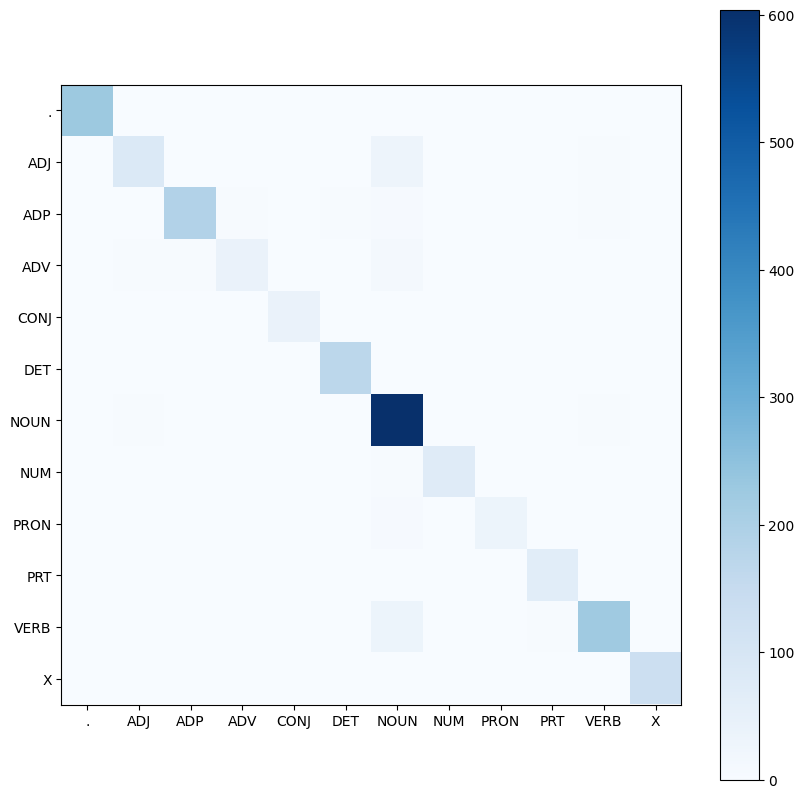

In [27]:
plt.figure(figsize=(10,10))
plt.xticks(np.arange(len(rf.classes_)),rf.classes_)
plt.yticks(np.arange(len(rf.classes_)),rf.classes_)
plt.imshow(conf_matrix,cmap=plt.cm.Blues)
plt.colorbar()

In [29]:
feature_list = zip(dict_vectorizer.get_feature_names_out(),rf.feature_importances_)
sorted_features = sorted(feature_list,key=lambda x: x[1], reverse=True)
print(sorted_features[0:20])

[('dist_from_last', 0.019498441090484927), ('prefix1=*', 0.015833420784290415), ('capitalized', 0.012903955683665862), ('suffix2=ed', 0.011387701314571641), ('suffix2=he', 0.011039155932740718), ('suffix2=,', 0.010870505227552922), ('suffix1=d', 0.01049982553332407), ('word=the', 0.010303896044352214), ('dist_from_first', 0.009944531247940473), ('prefix2=th', 0.009639585632572927), ('prefix1=,', 0.009455507453927356), ('prefix3=the', 0.009271342078037594), ('prefix1=t', 0.00908984842760069), ('word=,', 0.009023748094277678), ('suffix3=.', 0.008772118687666227), ('suffix1=s', 0.00822670179857221), ('numeric', 0.007310868885729465), ('suffix3=,', 0.006612290736349164), ('prefix3=,', 0.006566479367774474), ('suffix3=the', 0.006233406861309316)]
